In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
from functools import partial

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# using a pretrained model 

In [2]:
model = keras.applications.resnet.ResNet50(weights='imagenet')


In [3]:
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])

In [4]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

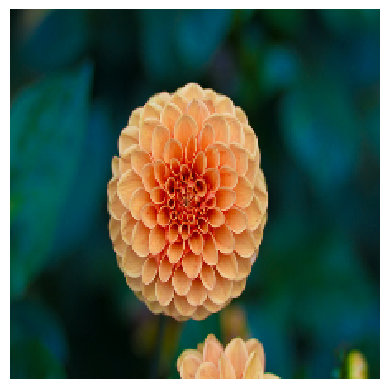

In [5]:
# reize image shape to shape on input_shape of resnet 50
images_resized = tf.image.resize(images, [224,224])
plot_color_image(images_resized[1])

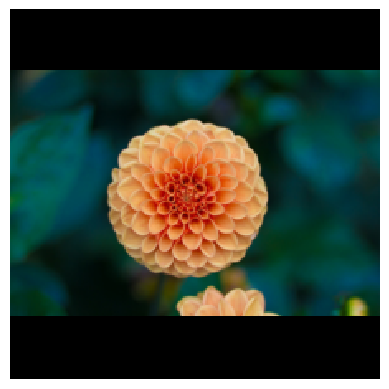

In [6]:
# Resize with pad
images_resized_pad = tf.image.resize_with_pad(images,224,224,antialias=True)
plot_color_image(images_resized_pad[1])

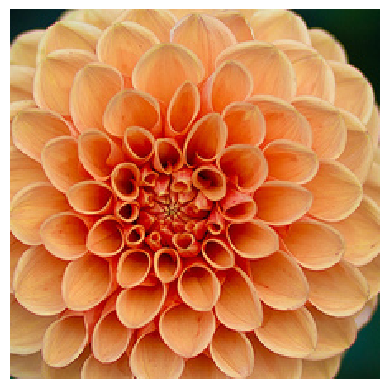

In [7]:
images_resized_crop_or_pad = tf.image.resize_with_crop_or_pad(images,224,224)
plot_color_image(images_resized_crop_or_pad[1])

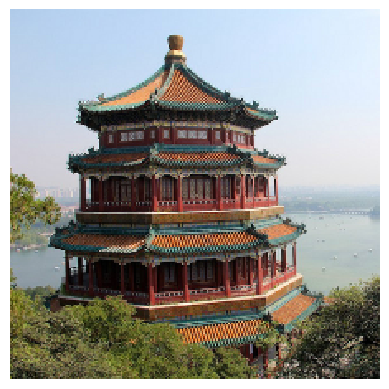

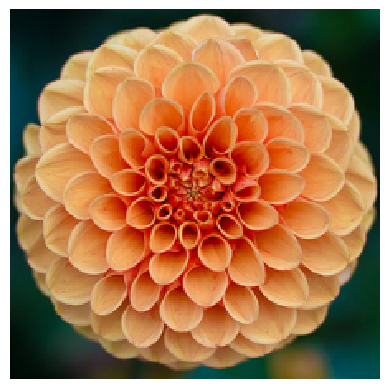

In [8]:
# reize approrch the size definition

# crop size
cihna_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
image_resized_and_crop = tf.image.crop_and_resize(images, [cihna_box, flower_box], [0,1], [224,224])
plot_color_image(image_resized_and_crop[0])
plt.show()
plot_color_image(image_resized_and_crop[1])
plt.show()

In [9]:
images.shape

(2, 427, 640, 3)

In [10]:
images_resized_pad.shape

TensorShape([2, 224, 224, 3])

In [11]:
images_resized.shape

TensorShape([2, 224, 224, 3])

In [12]:
images_resized_crop_or_pad.shape


TensorShape([2, 224, 224, 3])

In [13]:
image_resized_and_crop.shape

TensorShape([2, 224, 224, 3])

In [14]:
inputs = keras.applications.resnet50.preprocess_input(image_resized_and_crop * 255) #preprocess input
Y_proba = model.predict(inputs)

1/1 [==============================] - 4s 4s/step


In [15]:
print(Y_proba)
print(Y_proba.shape)
print(np.argmax(Y_proba,axis=1))

[[7.3529711e-09 2.1550377e-08 7.4669257e-09 ... 1.7053464e-09
  1.1168397e-07 3.3814896e-08]
 [2.3453514e-07 7.0248570e-06 4.0475337e-07 ... 5.3985412e-05
  3.6657166e-05 1.3363607e-04]]
(2, 1000)
[698 883]


In [16]:
top_k = keras.applications.resnet50.decode_predictions(Y_proba,top=3)
for image_index in range(len(images)):
    print(f"Images #{image_index}")
    for class_id, name, Y_proba in top_k[image_index]:
        print(" {} - {:12s} {:.2f}%".format(class_id,name,Y_proba *100))
    print()

Images #0
 n03877845 - palace       43.39%
 n02825657 - bell_cote    43.08%
 n03781244 - monastery    11.69%

Images #1
 n04522168 - vase         53.97%
 n07930864 - cup          9.52%
 n11939491 - daisy        4.96%



# Pretrained Models for Transfer Learning


In [17]:
import tensorflow_datasets as tfds

In [18]:
dataset, info = tfds.load("tf_flowers",as_supervised=True, with_info=True)

In [19]:
info.splits

{'train': <SplitInfo num_examples=3670, num_shards=2>}

In [20]:
info.splits["train"]

<SplitInfo num_examples=3670, num_shards=2>

In [21]:
class_names = info.features['label'].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [22]:
n_classes = info.features['label'].num_classes
n_classes

5

In [23]:
dataset_size = info.splits['train'].num_examples
dataset_size

3670

**Warning:** TFDS's split API has evolved since the book was published. The [new split API](https://www.tensorflow.org/datasets/splits) (called S3) is much simpler to use:

In [24]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

In [25]:
test_set_raw

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [26]:
valid_set_raw

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [27]:
train_set_raw

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

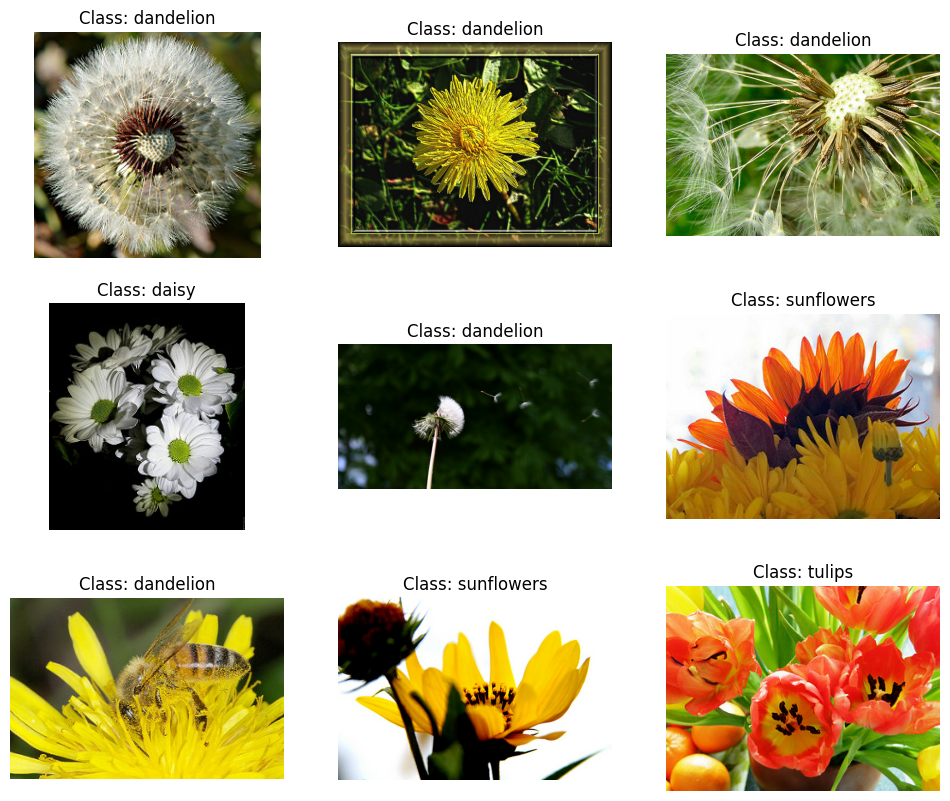

In [28]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

### Basic Preprocessing

In [29]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

### Data augmentation

In [30]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

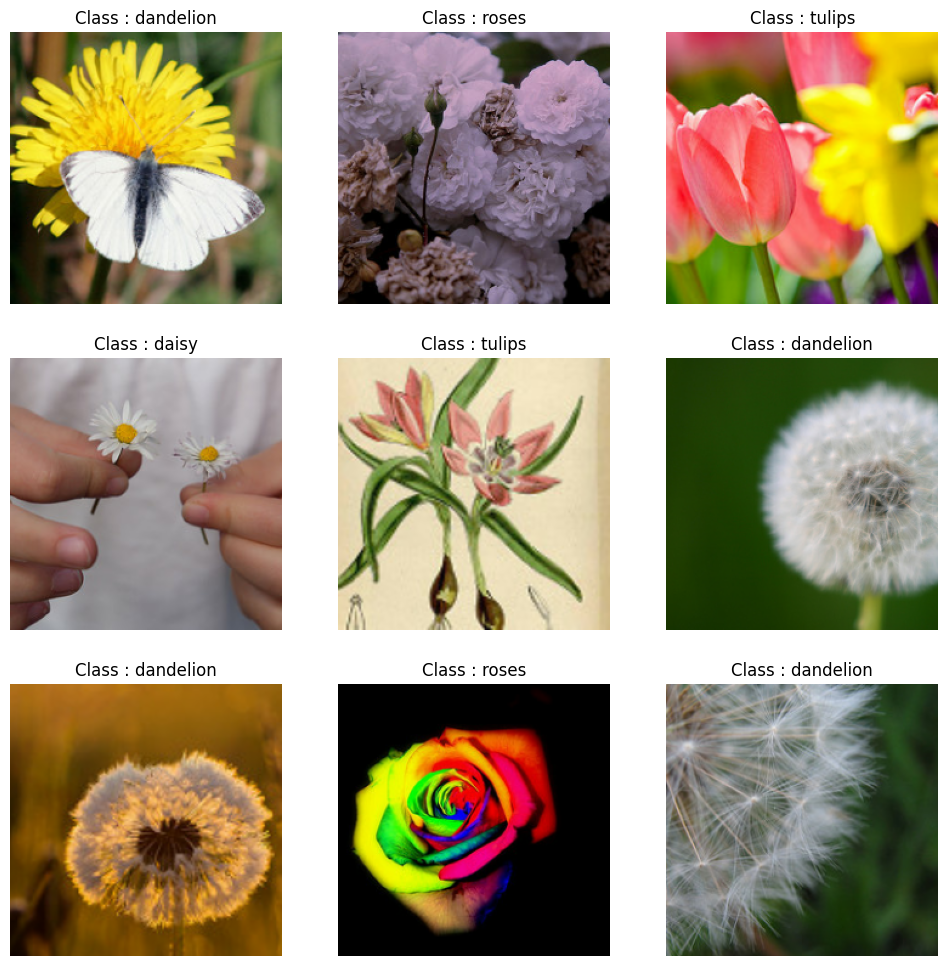

In [31]:
plt.figure(figsize=(12,12))
for x_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(x_batch[index] / 2 + 5e-1)
        plt.title(f"Class : {class_names[y_batch[index]]}")
        plt.axis("off")
plt.show()

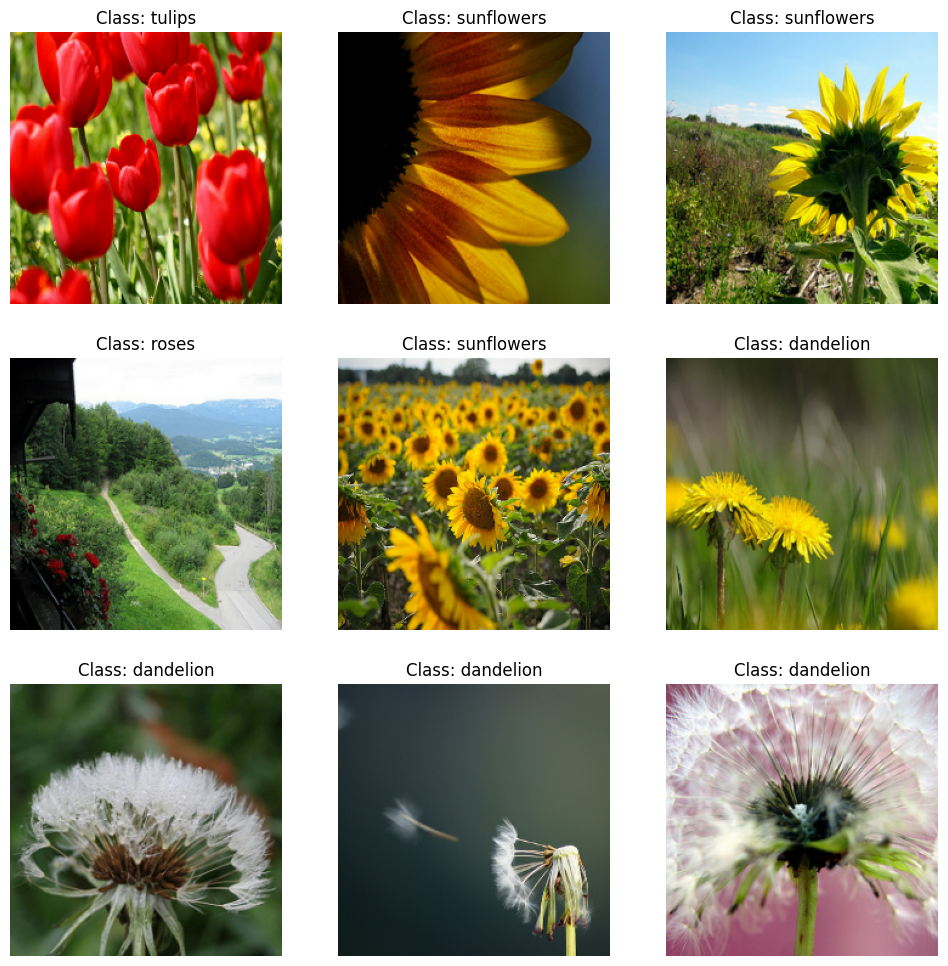

In [32]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [33]:
model_xception = keras.applications.xception.Xception(weights="imagenet")

In [34]:
model_xception.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [35]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [36]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_3[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                        

- if we compare that's result one and two is the top layer be cut of to pretrained

In [37]:
model_xception.output

<KerasTensor: shape=(None, 1000) dtype=float32 (created by layer 'predictions')>

In [38]:
base_model.output

<KerasTensor: shape=(None, None, None, 2048) dtype=float32 (created by layer 'block14_sepconv2_act')>

In [39]:
base_model.input

<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_3')>

In [40]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_3[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                           

In [41]:
# to know per layers name
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_3
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_4
13 block2_pool
14 batch_normalization_4
15 add_12
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_5
23 block3_pool
24 batch_normalization_5
25 add_13
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_6
33 block4_pool
34 batch_normalization_6
35 add_14
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_15
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

### Freeze layer
- must be compile after freeze and train the freeze layer to get 

In [42]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 173s 2s/step - loss: 1.1937 - accuracy: 0.8027 - val_loss: 0.8961 - val_accuracy: 0.8346
Epoch 2/5
86/86 [==============================] - 160s 2s/step - loss: 0.4927 - accuracy: 0.8950 - val_loss: 0.7596 - val_accuracy: 0.8621
Epoch 3/5
86/86 [==============================] - 149s 2s/step - loss: 0.2778 - accuracy: 0.9237 - val_loss: 0.6865 - val_accuracy: 0.8640
Epoch 4/5
86/86 [==============================] - 161s 2s/step - loss: 0.2069 - accuracy: 0.9371 - val_loss: 0.6483 - val_accuracy: 0.8695
Epoch 5/5
86/86 [==============================] - 146s 2s/step - loss: 0.1739 - accuracy: 0.9488 - val_loss: 0.6152 - val_accuracy: 0.8658


In [43]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_3[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                        

### Unfreeze Layer

In [44]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40


ResourceExhaustedError: Graph execution error:

Detected at node 'model/block2_sepconv2/separable_conv2d/depthwise' defined at (most recent call last):
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\traitlets\config\application.py", line 978, in launch_instance
      app.start()
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\Users\User\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\IPython\core\interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\IPython\core\interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\IPython\core\interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\User\AppData\Local\Temp\ipykernel_15976\1388464279.py", line 8, in <module>
      history = model.fit(train_set,
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "d:\Materi_data-science\Code\Computer_Vision\env\lib\site-packages\keras\layers\convolutional\separable_conv2d.py", line 188, in call
      outputs = tf.compat.v1.nn.separable_conv2d(
Node: 'model/block2_sepconv2/separable_conv2d/depthwise'
OOM when allocating tensor with shape[32,128,109,109] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/block2_sepconv2/separable_conv2d/depthwise}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_25766]

OOM stands for "out of memory". Your GPU is running out of memory, so it can't allocate memory for this tensor. There are a few things you can do:

- Decrease the number of filters in your Dense, Conv2D layers
- Use a smaller batch_size (or increase steps_per_epoch and validation_steps)
- Use grayscale images (you can use tf.image.rgb_to_grayscale)
- Reduce the number of layers
- Use MaxPooling2D layers after convolutional layers
- Reduce the size of your images (you can use tf.image.resize for that)
- Use smaller float precision for your input, namely np.float32
- If you're using a pre-trained model, freeze the first layers (like this)